In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

exec(open("ltco_utils.py", "r").read())

In [2]:
# -- set mpl defaults
plt.rcParams["image.interpolation"] = "nearest"

In [3]:
%matplotlib widget

In [4]:
# -- get the file list
dpath = "../data/LSPDD/"
flist = np.array(sorted([dpath + i for i in os.listdir(dpath) if "name" not in i]))


# -- get the associated spectrum numbers
nums = np.array([int(i.split("_")[1][:-4]) for i in flist])


# -- get the names database and create names array
names = pd.read_csv(dpath + "lspdd_name.csv")
names = names.set_index("num")["name"].loc[nums].values


# -- remove "bad" data (bad data and duplicate spectra)
bad_nums = [2737, 2764, 2768, 2772] + []
gind = [i for i, n in enumerate(nums) if n not in bad_nums]
flist = flist[gind]
nums = nums[gind]
names = names[gind]


# -- load the 2018 wavelengths and trim to fit within bounds
waves18 = get_wavelengths(2018)
twmin = np.max([np.min(pd.read_csv(i)["wavelength"]) for i in flist])
twmax = np.min([np.max(pd.read_csv(i)["wavelength"]) for i in flist])
wind = (waves18 >= twmin) & (waves18 <= twmax)
waves18 = waves18[wind]


# -- initialize the templates
templs = np.zeros((len(flist), len(waves18)))


# -- loop through files and interpolate
for ii, fname in enumerate(flist):
    waves, templ = pd.read_csv(fname).dropna().values.T
    templs[ii, :] = np.interp(waves18, waves, templ)


# -- normalize
templs = (templs - templs.min(axis=1, keepdims=True)) / \
            (templs.max(axis=1, keepdims=True) - templs.min(axis=1, keepdims=True))


# -- set the indices to keep
types = ["LED", "INC", "Halo", "MH", "CFL", "HPS"]
tinds = []

for ttype in types:
    tinds.append([i for i, n in enumerate(names) if ttype in n])

ginds = np.concatenate(tinds)


# -- split spectra into types
lspdd = [pd.DataFrame(data=templs[i].T, columns=nums[i]) for i in tinds]


# -- loop through types
lspdd_sub = []

for ii in range(len(lspdd)):
    tlspdd = lspdd[ii].copy()
    lspdd_sub.append(tlspdd)

    # -- find correlations within types
    corr = tlspdd.corr() > 0.95

    # -- recursively go through columns
    fin = False
    cols = tlspdd.columns
    ncol = len(cols)
    cind = 0

    while not fin:

        for jj in range(cind + 1, ncol):
            if corr.loc[cols[cind], cols[jj]]:
                tlspdd.drop(columns=cols[jj], inplace=True)

        cind += 1
        cols = tlspdd.columns
        ncol = len(cols)

        if cind == ncol:
            fin = True


# -- over-write LSPDD
lspdd = pd.concat(lspdd_sub, axis=1).reset_index(drop=True)


# -- filter combined list
corr = lspdd.corr() > 0.95


# -- recursively go through columns
fin = False
cols = lspdd.columns
ncol = len(cols)
cind = 0

while not fin:

    for jj in range(cind + 1, ncol):
        if corr.loc[cols[cind], cols[jj]]:
            lspdd.drop(columns=cols[jj], inplace=True)

    cind += 1
    cols = lspdd.columns
    ncol = len(cols)

    if cind == ncol:
        fin = True


# -- reset column names
lspdd.columns = names[[np.where(nums == i)[0][0] for i in lspdd.columns.values]]
        

# -- add wavelengths
lspdd.insert(loc=0, column="wavelength", value=waves18)


# -- write out the results
np.save("../output/lspdd_lab_spectra_names.npy", lspdd.columns[1:].values)
np.save("../output/lspdd_lab_spectra.npy", lspdd[lspdd.columns[1:]].values)
np.save("../output/lspdd_lab_spectra_wavelengths.npy", lspdd["wavelength"].values.astype(float))

reading and parsing night_00000.hdr...
reading night_00000.raw...


In [291]:
# ii = 4

# plt.close("all")
# fig, ax = plt.subplots(figsize=(10, 5))
# ax.imshow(templs[tinds[ii]], aspect="auto")
# _ = ax.set_yticks(range(0, len(tinds[ii])))
# _ = ax.set_yticklabels(names[tinds[ii]])

In [292]:
# itype = 4
# ncol = 7
# nrow = np.max((len(tinds[itype]) // ncol + 1, 2))
# rat = nrow / ncol

# plt.close("all")
# fig, ax = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, rat * 10))
# for ii in range(len(tinds[itype])):
#     tax = ax[ii // ncol, ii % ncol]
#     tax.plot(waves18, templs[tinds[itype]][ii])
#     tax.set_title(nums[tinds[itype]][ii], va="center")

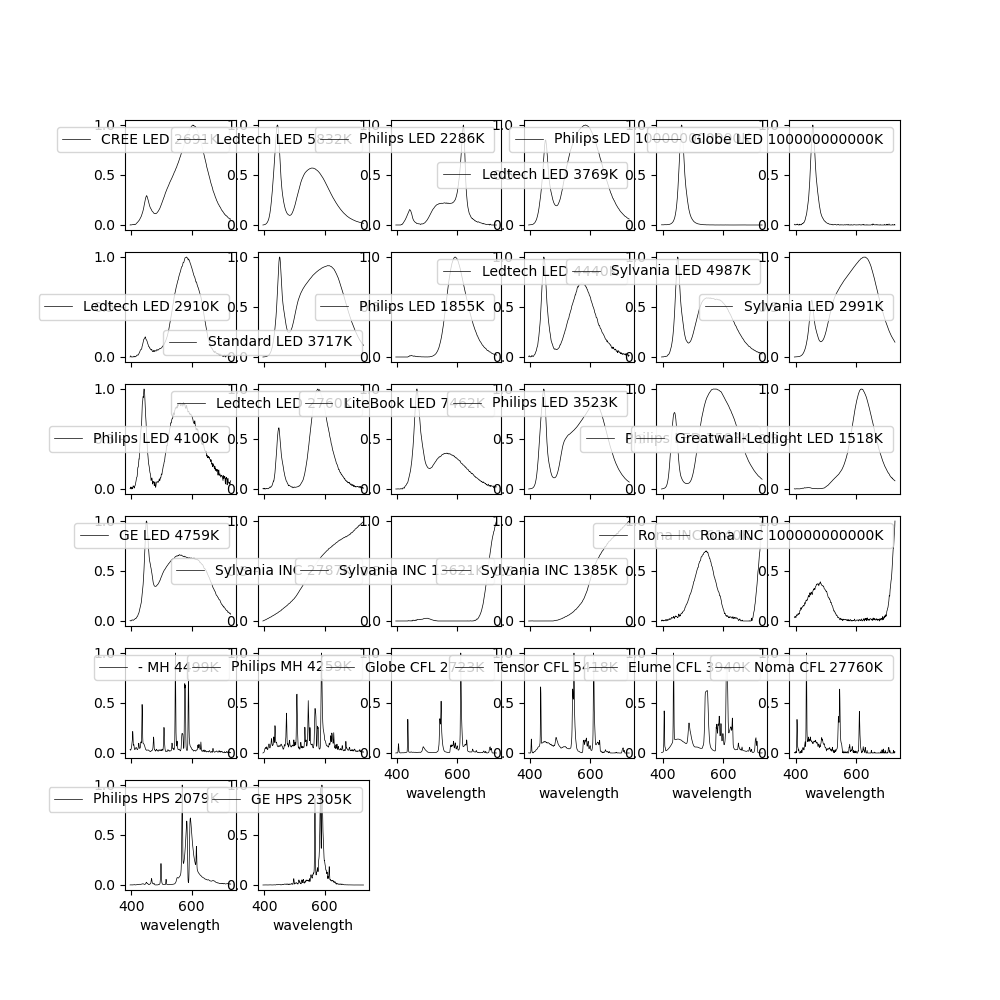

In [296]:
# plt.close("all")
# _ = lspdd.plot(x="wavelength", subplots=True, layout=(6, 6), color="k", lw=0.5, figsize=(10, 10))